## Final Project Submission

Please fill out:
* Student name: Jacob Crabb/ Taeho Jeon
* Student pace: full time 
* Instructor name: Greg/Miles
* Blog post URL:


# Goals for this project

search for best price


In [156]:
#import our libraries
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

from pandasql import sqldf
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

#initial setup for plt
plt.style.use('bmh')

#set up our sql variables
pysqldf = lambda q: sqldf(q, globals())

In [157]:
#set our dataframe
df = pd.read_csv('kc_house_data.csv')

In [158]:
#check out some of the column values
print(df.condition.unique())

print(df.grade.unique())

[3 5 4 1 2]
[ 7  6  8 11  9  5 10 12  4  3 13]


In [159]:
#explore our dataframe
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [160]:
#see what relates to what
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


In [161]:
#look at the low end of values
df.price.sort_values().head()

15279    78000.0
465      80000.0
16184    81000.0
8267     82000.0
2139     82500.0
Name: price, dtype: float64

In [162]:
#make sure that all the values are numbers
df.price.isna().sum()

0

In [163]:
#check out just the square foot living column
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

## Locations at a glance

where our homes are located

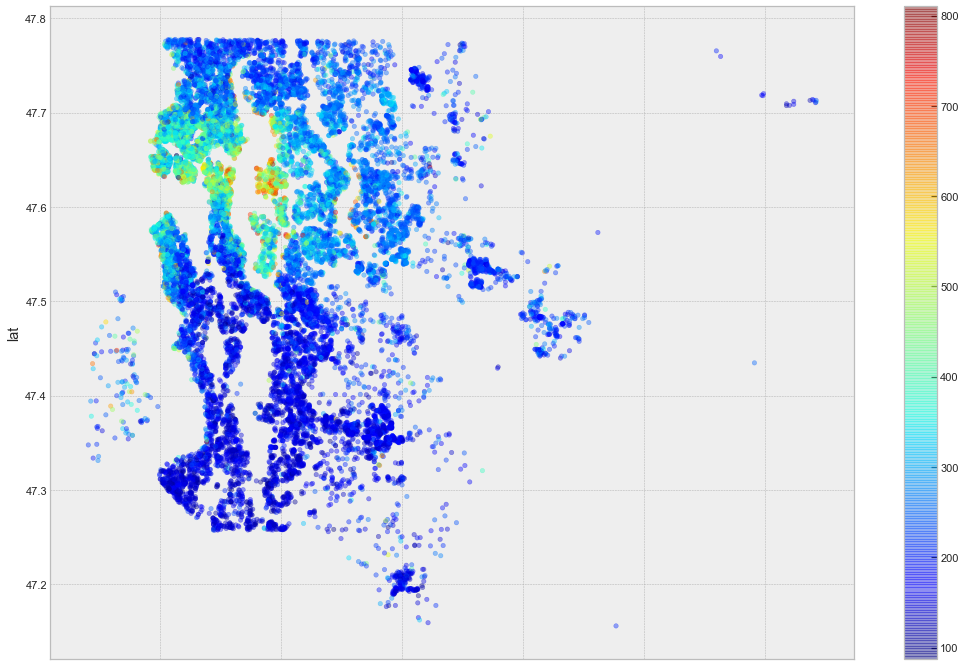

In [164]:
_ = df.plot(kind='scatter', x='long', y='lat', 
            c=df['price']/df['sqft_living'], 
            cmap=plt.get_cmap("jet"), 
            colorbar=True,
            alpha=0.4, 
            figsize=(18, 12))

# our first model:
square footage of living space has a high correlation to price, plus intuitively it makes sense to start the model here

In [165]:
#set some variables for our regression
X = df.sqft_living
y = df.price

In [166]:
slope, intercept, rvalue, pvalue, stderr = linregress(X,y)
first_model_y = slope*X + intercept

In [167]:
#check out our regression variables
linregress(X,y)

LinregressResult(slope=280.8630143588746, intercept=-43988.892194227315, rvalue=0.7019173021377599, pvalue=0.0, stderr=1.9394099144299841)

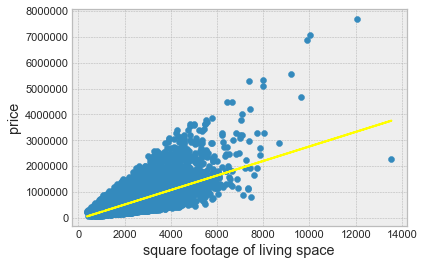

In [168]:
plt.scatter(X, y)
plt.plot(X,first_model_y,color='yellow')
plt.xlabel('square footage of living space')
plt.ylabel('price')
plt.show()

# improving our model
go for a more advanced attempt at least squares regression:

we start by looking for outliers:

In [169]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [170]:
#look at the low end of square foot
df.sqft_living.sort_values().tail()

8085      9640
9245      9890
3910     10040
7245     12050
12764    13540
Name: sqft_living, dtype: int64

In [171]:
#finding many outliers
remove_outliers = df.loc[(df.price >= 4500000) | (df.sqft_living >= 8000)].index

In [172]:
#remove those many outliers
df = df.drop(index=remove_outliers)

LinregressResult(slope=269.16985824582997, intercept=-21097.409936777083, rvalue=0.6939245606944319, pvalue=0.0, stderr=1.9011637923074614)


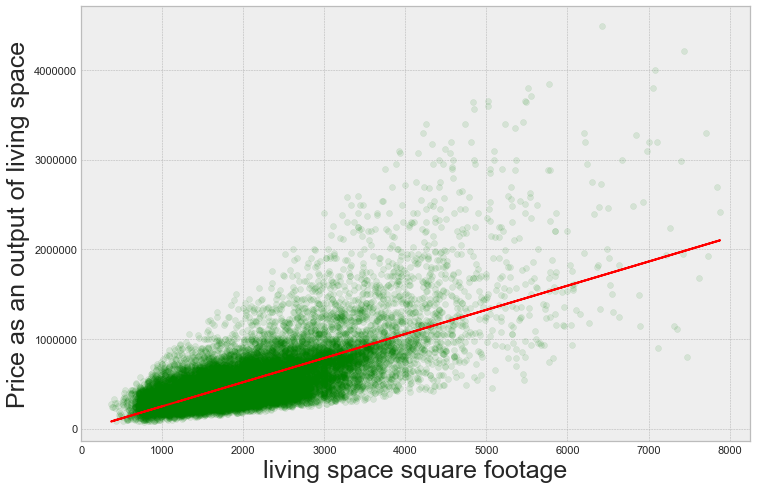

In [173]:
#see our new regression now that many extravaganatly
#large and expensive houses have been removed
X = df.sqft_living
y = df.price

slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

first_model_y = slope*X + intercept

print(linregress(X,y))

fig = plt.figure(figsize=(12,8))
plt.scatter(X,y, alpha=0.1, color='green')
plt.plot(X, first_model_y, color='red')
plt.xlabel('living space square footage',fontsize=25)
plt.ylabel('Price as an output of living space',fontsize=25)
plt.show()

# data cleaning:
replace NaN values to 0's, replace missing values with most common value.

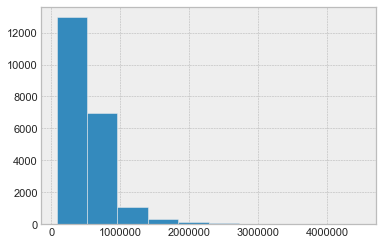

In [174]:
df.price.hist()

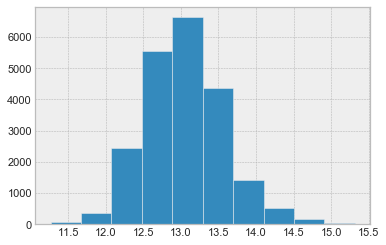

In [175]:
df.price = np.log(df.price)
df.price.hist()

In [176]:
df.view.replace(to_replace=np.NaN, value=0, inplace=True)
df.sqft_basement.replace(to_replace='?', value=0, inplace=True)
df.sqft_basement = df.sqft_basement.astype('float64')
df.waterfront.replace(to_replace=np.NaN, value=0, inplace=True)
df.yr_renovated.replace(to_replace=np.NaN, value=0, inplace=True)

In [177]:
#change year built to years old
df.yr_built = 2019 - df.yr_built

df = df.rename(columns={'yr_built': 'years_old'})

# prepare for multivariable regression

check for multicolinearity:

In [178]:
#_ = pd.plotting.scatter_matrix(df[['price', 'bedrooms', 'bathrooms', 
#                                   'sqft_living', 'floors', 'waterfront', 
#                                   'view', 'condition', 'years_old']], figsize=(12, 12))

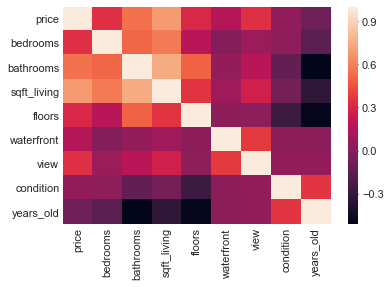

In [179]:
X = df[['price','bedrooms','bathrooms','sqft_living', 'floors', 'waterfront', 'view', 'condition', 'years_old']]
sns.heatmap(X.corr())

# functions for regression
do test train splits and cross validation

In [180]:
def do_predict(X, y):
    """Perform linear regression with X and y"""
    """Return a linear regression model and model scores"""
    """Takes array like objects for X and y"""
    
    #run a train test split on our variables
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.2,
                                                       random_state=27)
    #perform our regression and fit
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    #set a variable to our r squared for our test set
    r2_score = lr.score(X_test, y_test)
    
    #set a variable fore adjusted r squared
    adj_r2_score = 1 - (1-r2_score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    #set a variable to our test prediction
    y_pred = lr.predict(X_test)
    
    #variable for mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    #variable for our root mean squared error
    rmse = np.sqrt(mse)
    
    #perform a cross validation with our data set
    scores = cross_val_score(lr, X, y,
                            scoring='neg_mean_squared_error', cv=10)
    
    #root mean squared error result of our cross validation
    rmse_scores = np.sqrt(-scores)
    
    #return a model & scores
    return lr, {'R2':  r2_score,
            'ADJ R2': adj_r2_score,
            'RMSE':  rmse,
            'RMSE_SCORES':   rmse_scores,
            'Mean':  rmse_scores.mean(),
            'Std':  rmse_scores.std()
            }


In [181]:
def do_validate_model(model, X, y):
    """Perform a model validation"""
    """Return a model score with X, y"""
    # get r2 value
    r2_score = model.score(X, y)
    
    #adjusted r2 value
    adj_r2_score = 1 - (1-r2_score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    # get predict value with model
    y_pred = model.predict(X)
    
    # calculate rmse with predicted value
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    # perform a cross validation with data set
    scores = cross_val_score(model, X, y,
                            scoring='neg_mean_squared_error', cv=10)
    
    # root mean squared error result of our cross validation
    rmse_scores = np.sqrt(-scores)
    
    return {'R2':  r2_score,
            'ADJ R2': adj_r2_score,
            'RMSE':  rmse,
            'RMSE_SCORES':   rmse_scores,
            'Mean':  rmse_scores.mean(),
            'Std':  rmse_scores.std()
            }

# do more research into predictions by zipcode


In [182]:
#how many different zipcodes do we have?
df.zipcode.value_counts().size

70

In [183]:
#make a new column for seattle zip codes
df['Seattle_zip'] = 0

In [184]:
#try yet more different variables
X = df.loc[:,['sqft_living','condition', 'view', 'waterfront']]
y = df.price

In [185]:
#try again
do_predict(X,y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.5044896257747893,
  'ADJ R2': 0.5043977795515779,
  'RMSE': 0.36651238637472,
  'RMSE_SCORES': array([0.36398179, 0.38251783, 0.36959842, 0.3668093 , 0.36450068,
         0.36664002, 0.3708995 , 0.37267102, 0.36833658, 0.33672508]),
  'Mean': 0.3662680208098498,
  'Std': 0.011060934520356511})

In [186]:
#lets just pull out all the stops and let everything
#be a predictor for price
X = df.drop(columns=['price','date','id'], axis=1)
y = df.price

In [187]:
#show results
lr, result = do_predict(X,y)

In [188]:
#how'd we do?
print(lr.coef_)
print(result)

[-1.55671094e-02  7.12773434e-02  1.17430723e-04  4.27249943e-07
  7.59801419e-02  3.79192555e-01  6.35616594e-02  6.31984611e-02
  1.58759174e-01  2.48045284e-05  3.88025858e-05  3.52305140e-03
  3.61217515e-05 -6.71091285e-04  1.39111478e+00 -1.57260457e-01
  9.50061492e-05 -1.65687701e-07  0.00000000e+00]
{'R2': 0.759454019448838, 'ADJ R2': 0.7592420846642114, 'RMSE': 0.2553649762383108, 'RMSE_SCORES': array([0.24836481, 0.25993162, 0.25341269, 0.25450603, 0.24648276,
       0.25568544, 0.25121027, 0.25894933, 0.25505264, 0.2482606 ]), 'Mean': 0.2531856202168575, 'Std': 0.004319549861621543}


In [189]:
#funciton for seeing what zip codes are in seattle
def is_it_in_seattle(x):
    seattle_zip_codes = [98101, 98102, 98104, 98105, 98108, 98109, 98112 ,98113, 98114,
                     98117, 98103, 98106, 98107, 98111, 98115, 98116, 98118, 98119,
                     98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 98122,
                     98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148,
                     98155, 98160, 98161, 98164, 98165, 98168, 98170, 98146, 98154,
                     98158, 98166, 98174, 98175, 98178, 98190, 98191, 98177, 98181,
                     98185, 98188, 98189, 98194, 98195, 98199, 98198]
    return x in seattle_zip_codes

In [190]:
#test it out
is_it_in_seattle(98101)

True

In [191]:
#set our Seattle_zip column to have true values
#if the zipcode is indeed in seattle
df.loc[df['zipcode'].apply(is_it_in_seattle) == True, 'Seattle_zip'] = 1

In [192]:
#how well does our model perform on homes only in seattle?
X = df.loc[df['Seattle_zip'] == 1,['sqft_living','condition', 'view', 'waterfront']]
y = df.price[df['Seattle_zip'] == 1]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.47783678907437965,
  'ADJ R2': 0.47760381050843403,
  'RMSE': 0.3537875662472261,
  'RMSE_SCORES': array([0.35467881, 0.37653948, 0.36057969, 0.35917229, 0.36113342,
         0.36190683, 0.36640853, 0.36634333, 0.36917706, 0.3248917 ]),
  'Mean': 0.3600831122699613,
  'Std': 0.01306085903806517})

In [193]:
#what about only houses 'Outside' of seattle
X = df.loc[df['Seattle_zip'] == 0,['sqft_living','condition', 'view', 'waterfront']]
y = df.price[df['Seattle_zip'] == 0]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.574832520849759,
  'ADJ R2': 0.5746976540839699,
  'RMSE': 0.3502511752486563,
  'RMSE_SCORES': array([0.3475267 , 0.36820977, 0.359526  , 0.35696887, 0.34412005,
         0.35340449, 0.3467122 , 0.35987497, 0.34755434, 0.30880042]),
  'Mean': 0.34926977958414945,
  'Std': 0.015262917246937584})

# making dataframes by zipcode

In [194]:
#use sql commands to call on rows by one zipcode.
def get_dataframe_by_zip(x):
    q = f"SELECT * FROM df WHERE zipcode={x}"
    return pysqldf(q)
    

In [195]:
# get model by whole df
X = df.drop(columns=['price','date','id'], axis=1)
y = df.price

model, result = do_predict(X, y)

In [196]:
#perform our regression on each individual
#zipcode and see how we do
zip_result = []
zipcodes = df.zipcode.unique()
zipcodes.sort()
for zipcode in zipcodes:
    zip_df = get_dataframe_by_zip(zipcode)
    
    X = zip_df.drop(columns=['price','date','id'], axis=1)
    y = zip_df.price

    result = do_validate_model(model, X, y)
    zip_result.append((zipcode, result['Mean']))


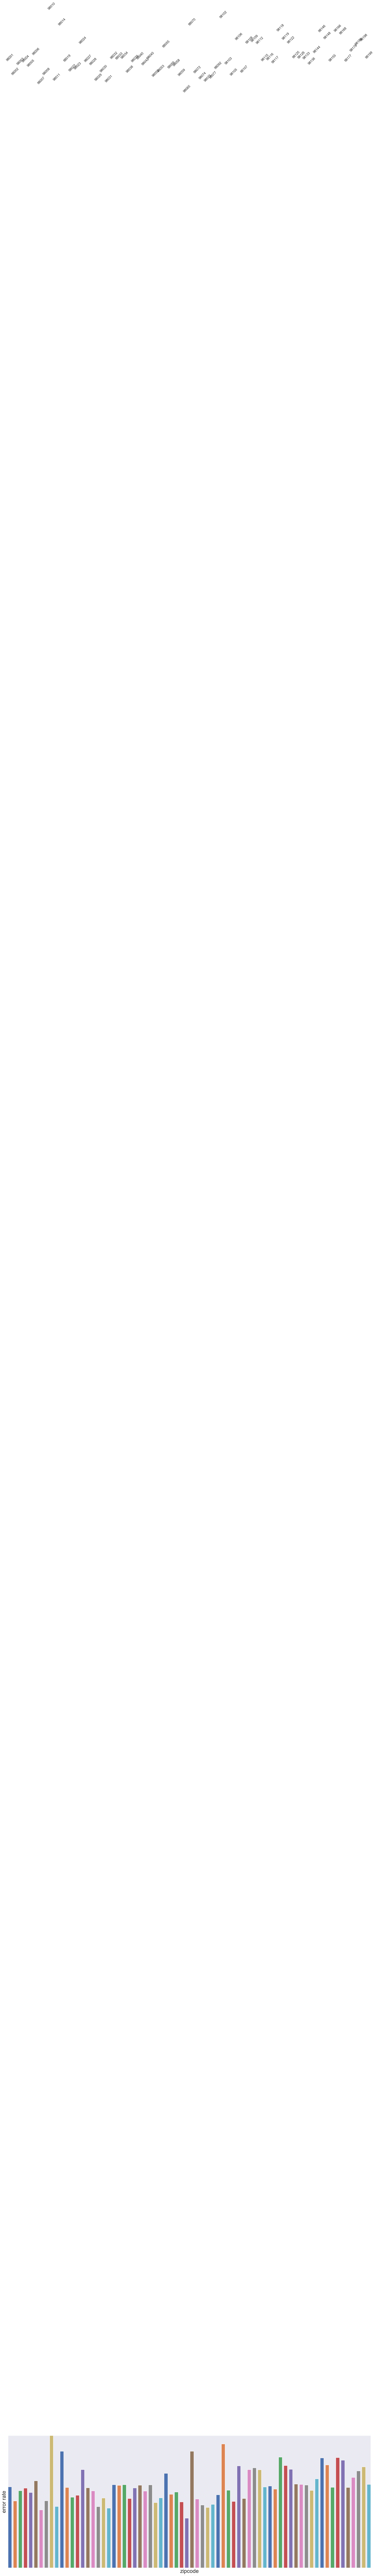

In [197]:
#plot our results
sns.set()
fig, ax = plt.subplots(figsize=(24, 9), dpi=120)

rects = ax.patches
ax.autoscale(tight=True)

zipcodes = []
rmses = []
for zipcode, mean_rmse in zip_result:
    zipcodes.append(str(zipcode))
    rmses.append(mean_rmse)
    ax.bar(str(zipcode), mean_rmse, width=.7)

fig.set_title = "Model fitting score by zipcode" 
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('zipcode', fontsize=20)
ax.set_ylabel('error rate', fontsize=20)

for rect, label in zip(rects, zipcodes):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
           ha='center', va='bottom', rotation=45)

In [198]:
zip_loc_df = pd.read_csv('wa_zip_lat_lng.csv', delimiter=';')
zip_loc_df.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,98063,Federal Way,WA,47.432251,-121.803388,-8,1,"47.432251, -121.803388"
1,98070,Vashon,WA,47.416198,-122.468210,-8,1,"47.416198, -122.46821"
2,98101,Seattle,WA,47.610670,-122.334380,-8,1,"47.61067, -122.33438"
3,98121,Seattle,WA,47.614870,-122.345780,-8,1,"47.61487, -122.34578"
4,98246,Bow,WA,48.558127,-121.417034,-8,1,"48.558127, -121.417034"


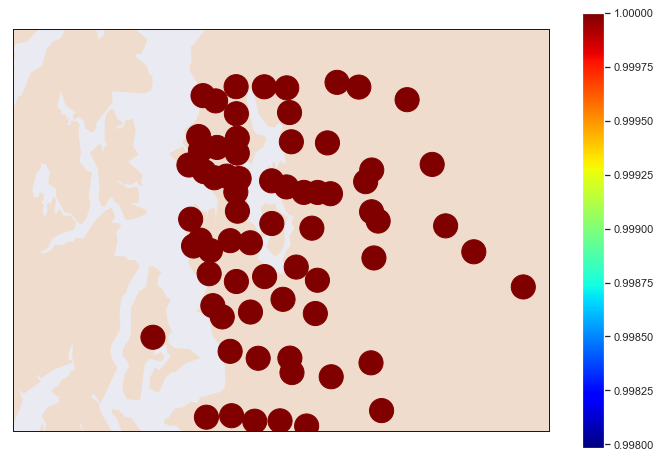

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# make the size proportional to the distance from the origin
s = [0.1*np.linalg.norm([a, b]) for a, b in zip(zipcodes, rmses)]
s = [a / max(s) for a in s]  # scale

# set color based on size
c = s
colors = [plt.cm.jet(color) for color in c]  # gets the RGBA values from a float

# # create a new figure
# plt.figure()
# ax = plt.gca()
# for a, b, color, size in zip(x, y, colors, s):
#     # plot circles using the RGBA colors
#     circle = plt.Circle((a, b), size, color=color, fill=False)
#     ax.add_artist(circle)
    

m = Basemap(projection='stere', lat_0=df.lat.mean(), lon_0=df.long.mean(),
            width=80000, height=60000, resolution='h', ax=ax)
m.fillcontinents(color="#F5D0A9", lake_color='#A9E2F3', alpha=.5)
m.drawmapboundary()

for zipcode, rmse, color in zip(zipcodes, rmses, colors):
    location = zip_loc_df.loc[zip_loc_df['Zip'] == int(zipcode), ['Latitude', 'Longitude']]
    lat = location.Latitude
    lng = location.Longitude

    lat = lat.values[0]
    lng = lng.values[0]

    circle = plt.Circle(xy=m(lng, lat),
                        radius=1800-(rmse/10000), 
                        fill=True,
                        color=color)
    ax.add_patch(circle)

# m.drawmapboundary()
# m.drawcoastlines()

plt.scatter(zipcodes,rmses,s=0, c=c, cmap='jet', facecolors='none')
plt.colorbar() 
plt.show()


# testing predictors
use sklearn feature ranking to pick predictors

In [200]:
#set variables for predictors and target
X = df.drop(columns=['price','date','id'])
y = df.price

In [201]:
#feature ranking with scikit learn
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 10)
selector = selector.fit(X, y)

In [202]:
#see our results
print(selector.support_)
print(selector.ranking_)

estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ True  True False False  True  True  True  True  True False False False
 False False  True  True False False  True]
[ 1  1  4  9  1  1  1  1  1  7  8  2  6  3  1  1  5 10  1]
[ 0.04335521  0.1047798  -0.00822276  0.41244003  0.10016888  0.10398988
  0.23365822  1.42338157  0.06768899  0.05548972]
-48.92433001193619


In [203]:
#set our features per their recomendation
X = df.loc[:, ['bedrooms','bathrooms','sqft_living','floors','grade','zipcode','lat','long','view','waterfront']]

In [204]:
y = df.price

In [205]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'zipcode',
       'lat', 'long', 'view', 'waterfront'],
      dtype='object')

In [206]:
#see our results
model, result = do_predict(X,y)

# Secondary Project Goals
find the best price based on customer needs:
bedrooms, bathrooms, city, condition, and house age

# tomorrow goals:
blog, presentation work, build model based on customer needs, improve markdowns, more code cleaning

In [207]:
def get_location(zipcode):
    location = zip_loc_df.loc[zip_loc_df['Zip'] == int(zipcode), ['Latitude', 'Longitude', 'City']]
    lat = location.Latitude
    lng = location.Longitude
    city_name = location.City

    lat = lat.values[0]
    lng = lng.values[0]
    city_name = city_name.values[0]
    
    return {
        'latitude': lat,
        'longitude': lng,
        'city_name': city_name
    }

    

In [208]:
get_location(98007)

{'latitude': 47.610935,
 'longitude': -122.14103999999999,
 'city_name': 'Bellevue'}

In [211]:
def price_predict(model,
                  result,
                  zipcode,
                  bedrooms,
                  bathrooms,
                  square_footage,
                  floors,
                  grade,
                  view=False,
                  waterfront=False,):
    
    location = get_location(zipcode)
    
    X = [[bedrooms, bathrooms, square_footage, floors, 
         grade, zipcode, location['latitude'], location['longitude'], view, waterfront ]]
    
              
    pred_price = np.exp(model.predict(X))
    pred_low_price = pred_price - (pred_price * (result['Mean'] / 2))
    pred_high_price = pred_price + (pred_price * (result['Mean'] / 2))
    
    result_value = {
        'predict_price': round(pred_price[0]),
        'predict_low_price': round(pred_low_price[0]),
        'predict_high_price': round(pred_high_price[0]),
        'city_name': location['city_name']
    }
    return result_value

In [212]:
price_predict(model, result, 98007, 2, 1, 1000, 1, 10)

{'predict_price': 548790.0,
 'predict_low_price': 474188.0,
 'predict_high_price': 623392.0,
 'city_name': 'Bellevue'}